In [15]:
import numpy as np
import pandas as pd
import networkx as nx

import geopandas as gpd
from shapely.geometry import Point

import folium
from folium.plugins import HeatMap

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings("ignore")

## **This notebook analyzes the following variables: Conductor Material, Type, Age, and Work Order Date**

Uses the same base as 'living_life_code.ipynb' by Judy

## 1. Preprocess the datasets

In [16]:
# vri_df = pd.read_csv('data/src_vri_snapshot_2024_03_20.csv')
span_df = pd.read_csv('data/dev_wings_agg_span_2024_01_01.csv')
gis_2024_1004 = pd.read_csv('data/gis_weatherstation_shape_2024_10_04.csv')
station_summary_2023_08_02 = pd.read_csv('data/src_wings_meteorology_station_summary_snapshot_2023_08_02.csv')
windspeed_2023_08_02 = pd.read_csv('data/src_wings_meteorology_windspeed_snapshot_2023_08_02.csv')

KeyboardInterrupt: 

In [ ]:
merged_df = pd.merge(station_summary_2023_08_02, gis_2024_1004, right_on= 'weatherstationcode', left_on='station', how='left')
merged_df.head()

,station,vri,alert,max_gust,99th,95th,snapshot_date_x,objectid,weatherstationcode,weatherstationname,...,elevation,twinguid,hftd,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date_y
0,AMO,H,35,40,32,24,2023-08-02,8.0,AMO,Ammo Dump,...,542.0,NaN,2.0,N,Y,NaN,{90874863-3E3A-4D88-A597-C531DBEE6E90},POINT (1556019.1347 12109260.1389),4431.0,10/4/2024
1,ANE,M,35,43,32,25,2023-08-02,89.0,ANE,Alpine,...,1814.0,NaN,2.0,N,Y,NaN,{53D5C3DA-4940-462A-AC06-26A36FC68783},POINT (1710032.1223 11916452.7548),4431.0,10/4/2024
2,ARH,L,40,46,40,31,2023-08-02,9.0,ARH,Archie Moore,...,1509.0,NaN,3.0,N,Y,NaN,{49DC14E1-2AE9-4575-93A8-C31AABF2AF48},POINT (1652898.10565 11993905.15735),4431.0,10/4/2024
3,AVO,H,35,43,29,24,2023-08-02,175.0,AVO,Avocado,...,658.0,NaN,2.0,N,Y,NaN,{35312FA1-D8E4-4D96-B61C-AEE1121077B5},POINT (1562731.0996 12122126.3274),4431.0,10/4/2024
4,AVY,L,45,62,53,40,2023-08-02,92.0,AVY,Anderson Valley,...,2667.0,NaN,3.0,N,Y,NaN,{CA560362-E0CE-495F-95A7-FE78A1AC3EBC},POINT (1717786.26886 11930149.546),4431.0,10/4/2024


In [ ]:
windspeed_grouped_count = windspeed_2023_08_02.groupby(by='station').count()
windspeed_grouped_count.head()

,date,wind_speed,snapshot_date
station,,,
AMO,179,166,179
ANE,179,179,179
ARH,179,179,179
AVO,179,179,179
AVY,179,116,179


In [ ]:
station_codes = np.array(gis_2024_1004['weatherstationcode'])
merged_station_df = gis_2024_1004.merge(station_summary_2023_08_02, left_on='weatherstationcode', right_on='station', how='left')


In [ ]:
merged_df[merged_df['weatherstationcode']=='AMO']['alert'].iloc[0]

prob_lst = []

for station in station_codes:
    station_windspeeds = np.array(windspeed_2023_08_02[windspeed_2023_08_02['station'] == station]['wind_speed'])
    # "alert" might be nan because of less entries in station_ss_df
    has_threshold = True
    try:
        threshold = merged_df[merged_df['weatherstationcode'] == station]['alert'].iloc[0]
    except:
        has_threshold = False
        prob = np.nan
    mean = np.nanmean(station_windspeeds)
    if has_threshold:
        prob = np.mean([1 if x >= threshold else 0 for x in station_windspeeds]) * 100
    count = np.count_nonzero(~np.isnan(station_windspeeds))
    prob_lst.append([station, station_windspeeds, threshold, count, mean, prob])

In [ ]:
prob_df = pd.DataFrame(prob_lst)
prob_df.columns = ['station', 'windspeeds', 'threshold', 'count', 'mean', 'probability (%)']
prob_df.head()

,station,windspeeds,threshold,count,mean,probability (%)
0,CBD,"[nan, nan, nan, nan, nan, nan, nan, nan, 11.0,...",35,171,16.251462,1.117318
1,CCR,"[31.0, 26.0, 27.0, 35.0, 24.0, 24.0, 25.0, 23....",45,179,31.413408,13.966480
2,CES,"[33.0, 25.0, 26.0, 38.0, 26.0, 24.0, 23.0, 19....",41,173,28.294798,7.262570
3,ROV,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",45,49,24.265306,2.793296
4,CHO,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",35,117,14.213675,0.000000


In [ ]:
gis_2024_1004['shape'] = gpd.GeoSeries.from_wkt(gis_2024_1004['shape'])
gis_gdf = gpd.GeoDataFrame(gis_2024_1004, geometry='shape').set_crs(epsg=4431).to_crs(epsg=4326)

# vri_df['shape'] = gpd.GeoSeries.from_wkt(vri_df['shape'])
# vri_gdf = gpd.GeoDataFrame(vri_df, geometry='shape').set_crs(epsg=4326)

span_df['shape'] = gpd.GeoSeries.from_wkt(span_df['shape'])
span_gdf = gpd.GeoDataFrame(span_df, geometry='shape').set_crs(epsg=2230).to_crs(epsg=4326)

In [ ]:
gis_gdf = gis_gdf.drop(columns=['shape_srid'])
# vri_gdf = vri_gdf.drop(columns=['shape_srid'])
span_gdf = span_gdf.drop(columns=['shape_srid'])


In [ ]:
# gis_vri_merge = gis_gdf.merge(vri_gdf, left_on='weatherstationcode', right_on='anemometercode')
# vri_gdf['centroid'] = vri_gdf['shape'].centroid
# vri_gis_sjoin = vri_gdf.sjoin(gis_gdf, how='inner')

In [ ]:
prob_merge = gis_gdf.merge(prob_df, left_on='weatherstationcode', right_on='station').merge(station_summary_2023_08_02, left_on='weatherstationcode', right_on='station')
prob_merge

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,count,mean,probability (%),station_y,vri,alert,max_gust,99th,95th,snapshot_date_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,171,16.251462,1.117318,CBD,M,35,39,33,25,2023-08-02
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,179,31.413408,13.966480,CCR,M,45,73,50,37,2023-08-02
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,173,28.294798,7.262570,CES,M,41,64,41,33,2023-08-02
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,49,24.265306,2.793296,ROV,L,45,64,47,33,2023-08-02
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,117,14.213675,0.000000,CHO,L,35,30,25,19,2023-08-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,146,HAU,Hauser Mountain,4828.0,Z972858,Mountain-258,4.0,1316-J1,A,calonzo,...,49,48.795918,16.201117,HAU,NaN,45,87,73,56,2023-08-02
217,223,BOB,Bob Owens Canyon,4841.0,Z571472,Inland Valley-250,4.0,1295-A7,A,CLCosby,...,45,24.933333,2.234637,BOB,M,45,52,42,30,2023-08-02
218,224,MWG,MT. WOODSON GOLF CLUB,4827.0,P518334,INLAND VALLEY-250,3.0,1171-D3,A,KSTETS,...,49,18.530612,0.000000,MWG,M,35,32,31,25,2023-08-02
219,4,CGD,Cole Grade,1957.0,Z416193,Inland Valley-250,3.0,1070-G1,A,seu_gis_elec,...,179,18.407821,0.558659,CGD,M,35,40,30,23,2023-08-02


In [ ]:
# vri_mapping = {'H': 2, 'M': 1, 'L': 0}
# prob_merge['vri_numeric'] = prob_merge['vri'].map(vri_mapping)

In [ ]:
# prob_merge.head()

In [18]:
span_df_cleaned = span_df.dropna(subset=['station'])
span_prob_merge_df = prob_merge.merge(span_df_cleaned, left_on='weatherstationcode', right_on='station')
span_prob_merge_df

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,exclusive_tree_ids,exclusive_tree_counts,transformer_counts,model_major_ver,model_minor_ver,model_patch_ver,snapshot_date,upstream_span_id,shape_y,shape_srid
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{290A717F-C209-47EE-83C1-57E082732C56},"LINESTRING (6248655.573 1994627.359, 6248653.1...",2230
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{C3C9EC8C-FA86-409B-BB21-39251C3362D0},"LINESTRING (6247093.344 1988997.506, 6247085.5...",2230
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{C89051A3-68E8-41D4-80F2-40F3F8A8BD2B},"LINESTRING (6221680.586 2021384.954, 6221680.4...",2230
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{900E2ACE-689F-4962-8A2E-571632650D56},"LINESTRING (6250043.938 1969545.021, 6250045.9...",2230
4,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{C5EDC30D-D2E9-47E4-9983-87F7A7FCD6B5},"LINESTRING (6243233.637 1975575.367, 6243234.2...",2230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373997,159,CLM,Creelman,1996.0,Z104188,Inland Valley-250,3.0,1172-G2,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{AC9D9B58-3CC5-4B97-AF23-C3BEFA06538E},"LINESTRING (6376640.069 1947824.484, 6376637.4...",2230
373998,159,CLM,Creelman,1996.0,Z104188,Inland Valley-250,3.0,1172-G2,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{7C458E05-FC2F-495E-AC85-C11C522DA355},"LINESTRING (6382346.739 1944350.983, 6382350.6...",2230
373999,159,CLM,Creelman,1996.0,Z104188,Inland Valley-250,3.0,1172-G2,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{EE7A23D3-627A-4953-9C95-CB3F3B25F950},"LINESTRING (6377296.688 1947551.112, 6377294.8...",2230
374000,159,CLM,Creelman,1996.0,Z104188,Inland Valley-250,3.0,1172-G2,A,seu_gis_elec,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{69AB04D8-B6B7-4E46-BEFF-39C806963783},"LINESTRING (6378019.122 1943888.186, 6378021.8...",2230


In [19]:
print(list(span_prob_merge_df.columns))

['objectid', 'weatherstationcode', 'weatherstationname', 'scadartuid', 'structureid', 'nwszone', 'district', 'thomasbrospagegrid', 'constructionstatus', 'creationuser', 'datecreated', 'datemodified', 'lastuser', 'structureguid', 'symbolrotation', 'latitude', 'longitude', 'elevation', 'twinguid', 'hftd_x', 'zone1idc', 'hftdidc', 'gdb_geomattr_data', 'globalid_x', 'shape_x', 'snapshot_date_x', 'station_x', 'windspeeds', 'threshold', 'count', 'mean', 'probability (%)', 'station_y', 'vri_x', 'alert', 'max_gust', '99th', '95th', 'snapshot_date_y', 'Unnamed: 0', 'globalid_y', 'ohug', 'feederid', 'upstreamardfacilityid', 'is_span', 'upstream_struct_id', 'upstream_struct_age', 'upstream_struct_material', 'upstream_struct_hftd', 'upstream_struct_type', 'upstream_struct_workorderdate', 'downstream_struct_id', 'downstream_struct_age', 'downstream_struct_material', 'downstream_struct_hftd', 'downstream_struct_type', 'downstream_struct_workorderdate', 'egress_population_max', 'egress_potential_impa

In [20]:
columns_to_keep = [
    'probability (%)',
    'hardened_state', 'miles', 
    'upstream_struct_age', 'upstream_struct_hftd', 'upstream_struct_material', 'upstream_struct_type', 'upstream_struct_workorderdate',
    'downstream_struct_age', 'downstream_struct_hftd', 'downstream_struct_material', 'downstream_struct_type', 'downstream_struct_workorderdate',
    'wire_risk',
]

df_filtered = span_prob_merge_df[columns_to_keep]

# columns_to_impute = ['num_strike_trees', 'buffered_tree_counts', 'exclusive_tree_counts']
# for col in columns_to_impute:
#     min_val, max_val = df_filtered[col].min(), df_filtered[col].max()
#     df_filtered[col] = df_filtered[col].apply(
#         lambda x: np.random.randint(min_val, max_val + 1) if pd.isna(x) else x
#     )

df_filtered.shape

(374002, 14)

In [21]:
# fix 'workorderdate' datatype from str to datetime
df_filtered['upstream_struct_workorderdate'] = df_filtered['upstream_struct_workorderdate'].replace('NaN',np.nan)
df_filtered['downstream_struct_workorderdate'] = df_filtered['downstream_struct_workorderdate'].replace('NaN',np.nan)

df_filtered['upstream_struct_workorderdate'] = pd.to_datetime(df_filtered['upstream_struct_workorderdate'],format='%Y-%m-%d')
df_filtered['downstream_struct_workorderdate'] = pd.to_datetime(df_filtered['downstream_struct_workorderdate'],format='%Y-%m-%d')

In [22]:
# calculate the days past since the last work order
upstream_workorder_days = pd.Timestamp.now() - df_filtered['upstream_struct_workorderdate']
df_filtered['days_since_upstream_workorder'] = [i.days for i in upstream_workorder_days]
downstream_workorder_days = pd.Timestamp.now() - df_filtered['downstream_struct_workorderdate']
df_filtered['days_since_downstream_workorder'] = [i.days for i in downstream_workorder_days]

# drop original columns
df_filtered = df_filtered.drop(columns=['upstream_struct_workorderdate', 'downstream_struct_workorderdate'])

In [23]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = ['hardened_state', 'wire_risk',
                       'upstream_struct_type', 'downstream_struct_type', 'downstream_struct_material', 'upstream_struct_material']
one_hot_encoded = encoder.fit_transform(df_filtered[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([df_filtered.drop(categorical_columns, axis=1), one_hot_df], axis=1)

In [24]:
df_encoded

,probability (%),miles,upstream_struct_age,upstream_struct_hftd,downstream_struct_age,downstream_struct_hftd,days_since_upstream_workorder,days_since_downstream_workorder,hardened_state_CC,hardened_state_TH,...,downstream_struct_material_FIBERGLASS,downstream_struct_material_STEEL,downstream_struct_material_WOOD,downstream_struct_material_nan,upstream_struct_material_CON,upstream_struct_material_FIB,upstream_struct_material_FIBERGLASS,upstream_struct_material_STEEL,upstream_struct_material_WOOD,upstream_struct_material_nan
0,1.117318,0.035985,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.117318,0.035985,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.117318,0.062500,NaN,NaN,10.666667,NaN,NaN,4302.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.117318,0.062500,27.250000,NaN,27.250000,NaN,10358.0,10358.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.117318,0.017045,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373997,8.379888,0.037879,41.166667,3.0,20.000000,NaN,15441.0,7710.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
373998,8.379888,0.008523,9.416667,NaN,19.750000,3.0,3849.0,7619.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
373999,8.379888,0.021023,43.000000,3.0,16.166667,NaN,16110.0,6310.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
374000,8.379888,0.036742,3.166667,3.0,20.000000,NaN,1584.0,7710.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
df_encoded.columns

Index(['probability (%)', 'miles', 'upstream_struct_age',
       'upstream_struct_hftd', 'downstream_struct_age',
       'downstream_struct_hftd', 'days_since_upstream_workorder',
       'days_since_downstream_workorder', 'hardened_state_CC',
       'hardened_state_TH', 'hardened_state_UG', 'hardened_state_UH',
       'hardened_state_nan', 'wire_risk_High', 'wire_risk_Low',
       'wire_risk_Medium', 'wire_risk_nan', 'upstream_struct_type_oh',
       'upstream_struct_type_surf', 'upstream_struct_type_ug',
       'upstream_struct_type_nan', 'downstream_struct_type_oh',
       'downstream_struct_type_surf', 'downstream_struct_type_ug',
       'downstream_struct_type_nan', 'downstream_struct_material_CON',
       'downstream_struct_material_FIB',
       'downstream_struct_material_FIBERGLASS',
       'downstream_struct_material_STEEL', 'downstream_struct_material_WOOD',
       'downstream_struct_material_nan', 'upstream_struct_material_CON',
       'upstream_struct_material_FIB', 'upstrea

## 2. EDA

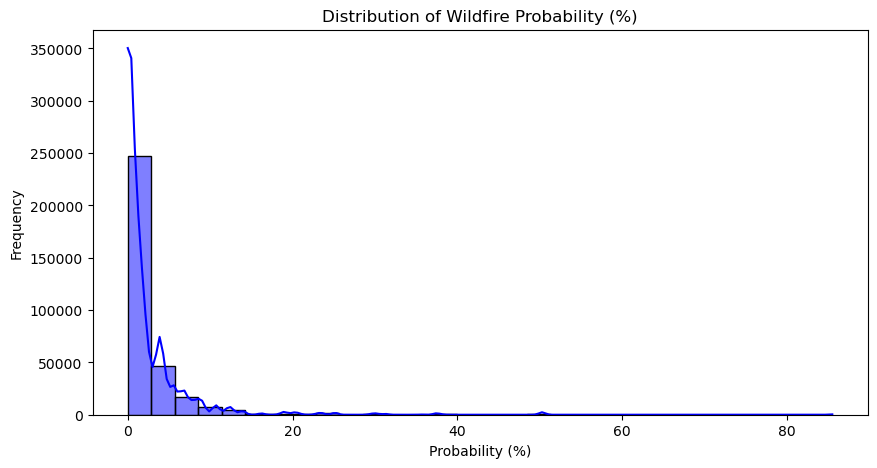

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered['probability (%)'], bins=30, kde=True, color='blue')
plt.title("Distribution of Wildfire Probability (%)")
plt.xlabel("Probability (%)")
plt.ylabel("Frequency")
plt.show()


<Axes: xlabel='upstream_struct_type', ylabel='probability (%)'>

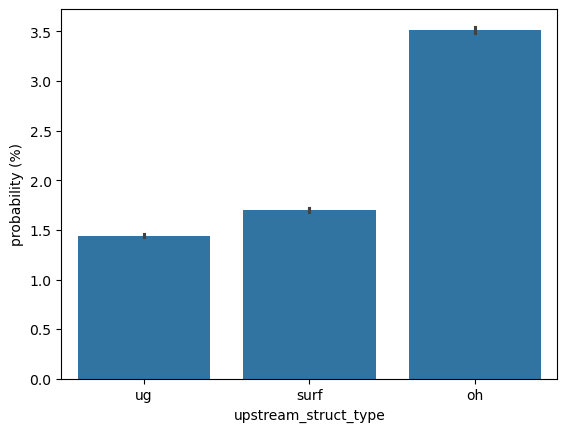

In [ ]:
sns.barplot(data=df_filtered, x='upstream_struct_type', y='probability (%)')

<Axes: xlabel='downstream_struct_type', ylabel='probability (%)'>

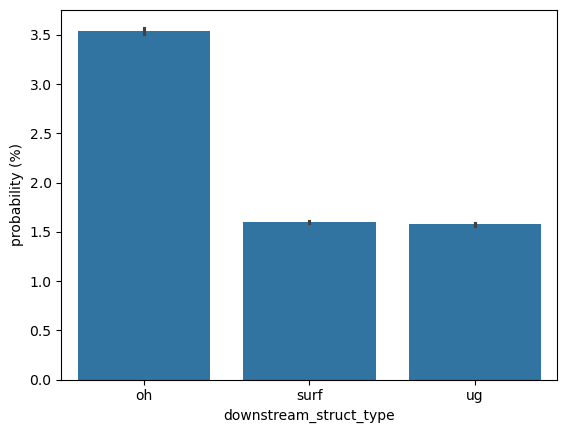

In [ ]:
sns.barplot(data=df_filtered, x='downstream_struct_type', y='probability (%)')

In [29]:
sorted_material = df_filtered['upstream_struct_material'].unique()
sorted_material

array(['CON', 'STEEL', 'WOOD', nan, 'FIBERGLASS', 'FIB'], dtype=object)

<Axes: xlabel='upstream_struct_material', ylabel='probability (%)'>

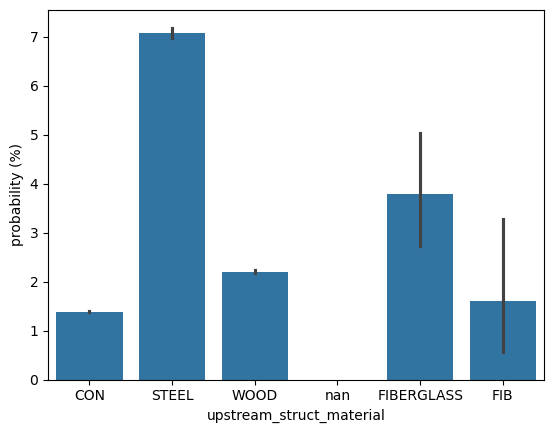

In [30]:
sns.barplot(data=df_filtered, x='upstream_struct_material', y='probability (%)', order=sorted_material)

<Axes: xlabel='downstream_struct_material', ylabel='probability (%)'>

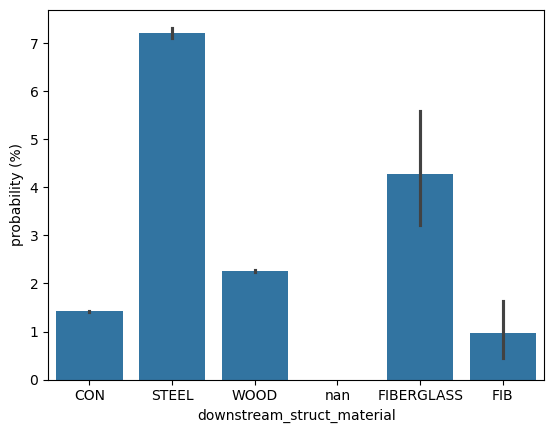

In [31]:
sns.barplot(data=df_filtered, x='downstream_struct_material', y='probability (%)', order=sorted_material)

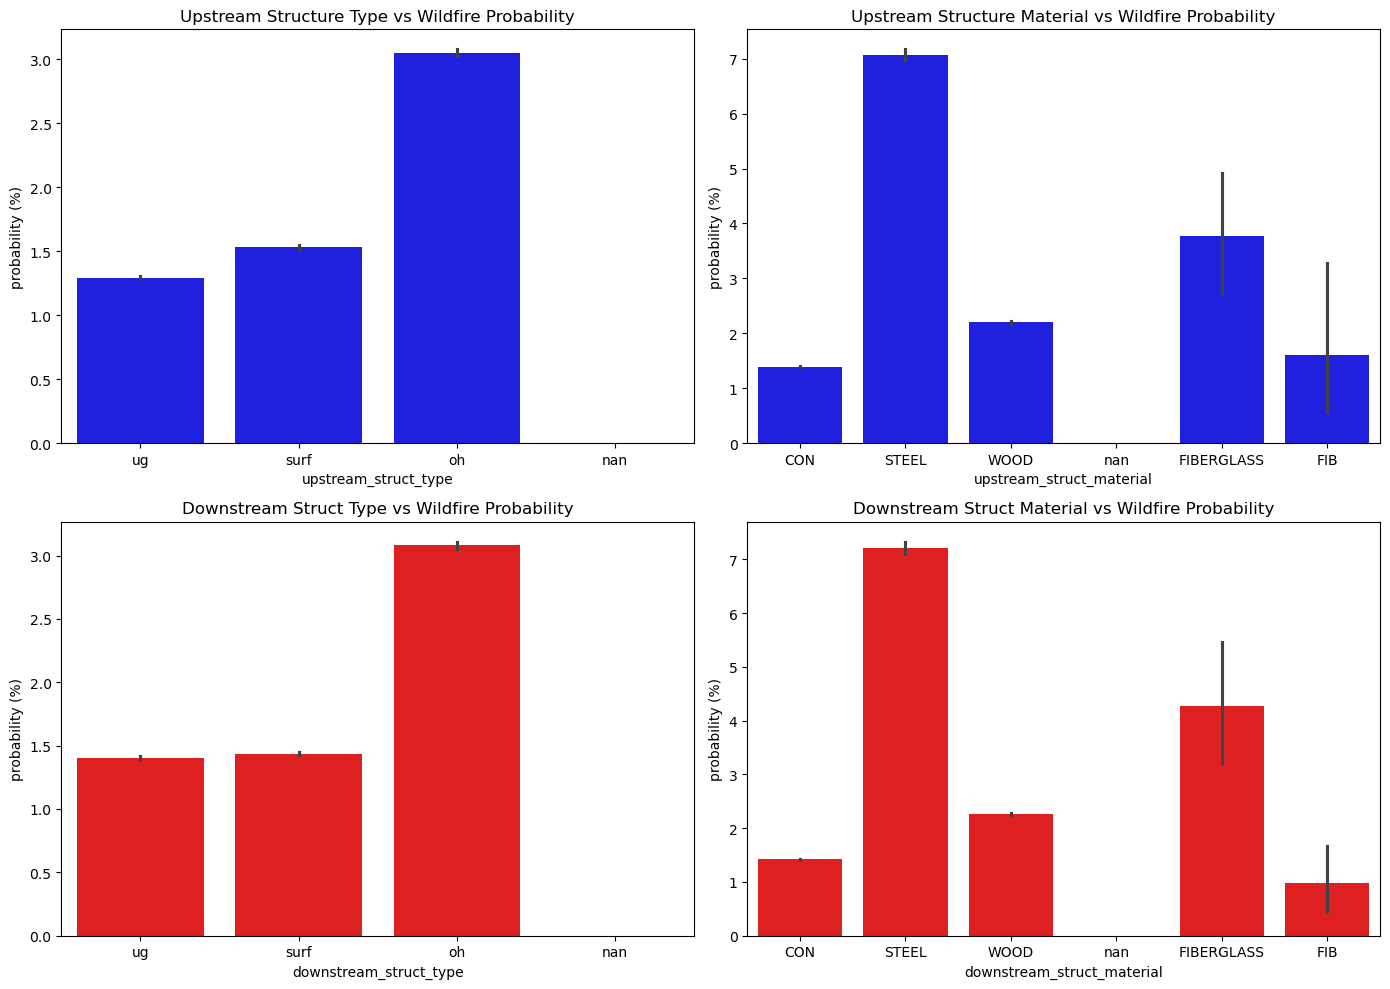

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sorted_type = df_filtered['upstream_struct_type'].unique()
sorted_material = df_filtered['upstream_struct_material'].unique()

sns.barplot(data=df_filtered, x='upstream_struct_type', y='probability (%)', order=sorted_type, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Upstream Structure Type vs Wildfire Probability")

sns.barplot(data=df_filtered, x='downstream_struct_type', y='probability (%)', order=sorted_type, ax=axes[1, 0], color='red')
axes[1, 0].set_title("Downstream Struct Type vs Wildfire Probability")

sns.barplot(data=df_filtered, x='upstream_struct_material', y='probability (%)', order=sorted_material, ax=axes[0, 1], color='blue')
axes[0, 1].set_title("Upstream Structure Material vs Wildfire Probability")

sns.barplot(data=df_filtered, x='downstream_struct_material', y='probability (%)', order=sorted_material, ax=axes[1, 1], color='red')
axes[1, 1].set_title("Downstream Struct Material vs Wildfire Probability")

plt.tight_layout()
plt.show()

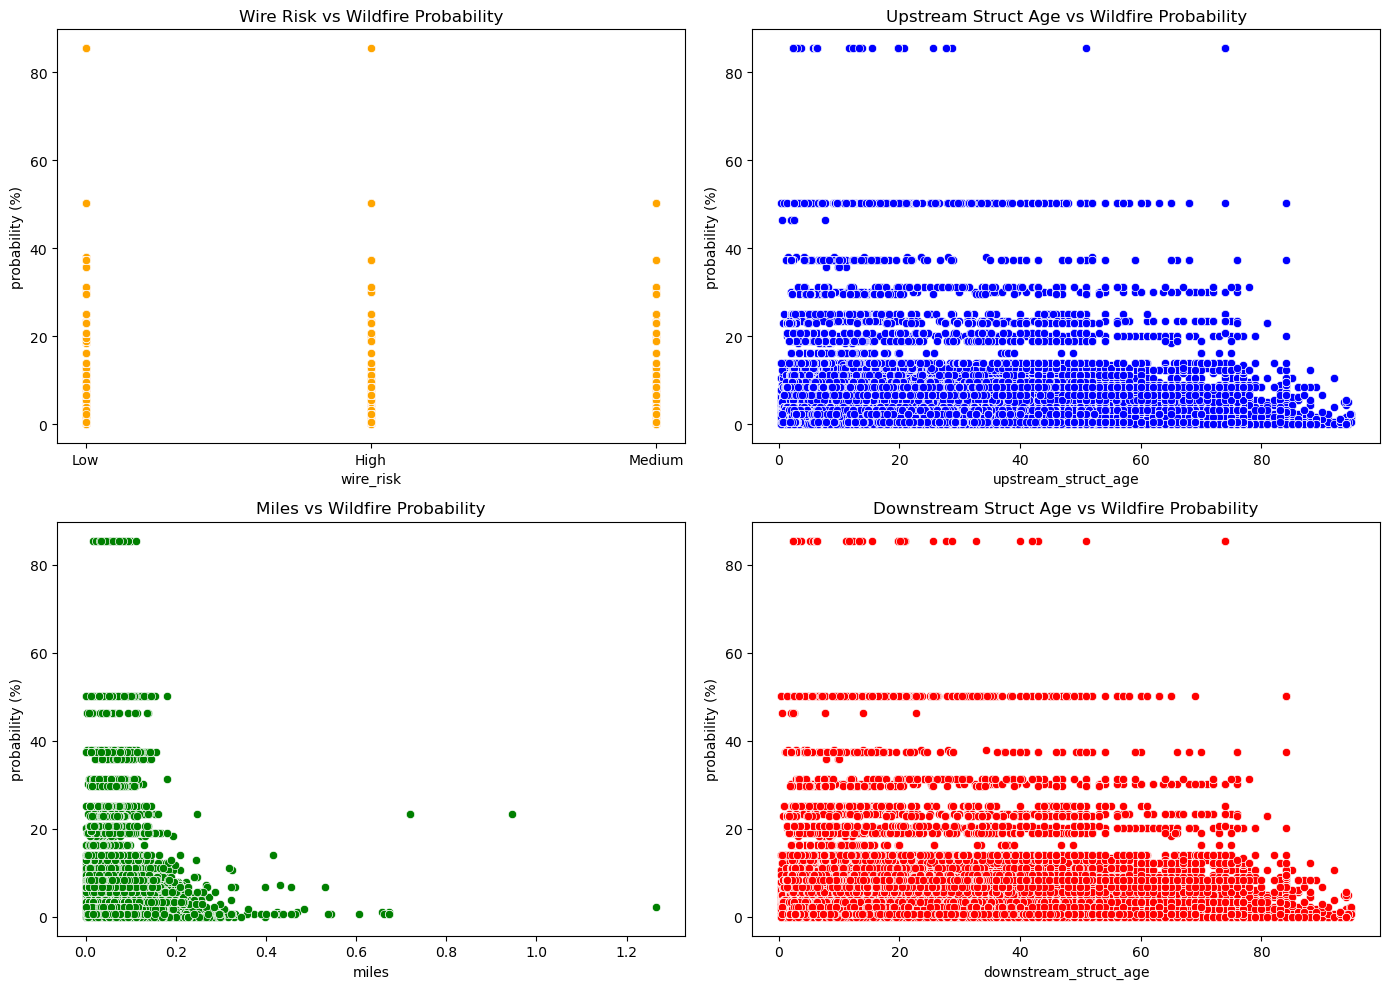

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(data=df_filtered, x='wire_risk', y='probability (%)', ax=axes[0, 0], color='orange')
axes[0, 0].set_title("Wire Risk vs Wildfire Probability")

sns.scatterplot(data=df_filtered, x='upstream_struct_age', y='probability (%)', ax=axes[0, 1], color='blue')
axes[0, 1].set_title("Upstream Struct Age vs Wildfire Probability")

sns.scatterplot(data=df_filtered, x='miles', y='probability (%)', ax=axes[1, 0], color='green')
axes[1, 0].set_title("Miles vs Wildfire Probability")

sns.scatterplot(data=df_filtered, x='downstream_struct_age', y='probability (%)', ax=axes[1, 1], color='red')
axes[1, 1].set_title("Downstream Struct Age vs Wildfire Probability")

plt.tight_layout()
plt.show()

## 3. ML models

In [40]:
# columns_to_impute = ['num_strike_trees', 'buffered_tree_counts', 'exclusive_tree_counts']
# for col in columns_to_impute:
#     min_val, max_val = df_encoded[col].min(), df_encoded[col].max()
#     df_encoded[col] = df_encoded[col].apply(
#         lambda x: np.random.randint(min_val, max_val + 1) if pd.isna(x) else x
#     )

X = df_encoded.drop(columns=['probability (%)'])
y = df_encoded['probability (%)']

imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=25, random_state=30),
    # "Support Vector Regressor": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    # "MLP Regressor": MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=300, random_state=42)
}

results = []
for name, model in models.items():
    if name in ["Random Forest", "Linear Regression"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MAE": mae, "MSE": mse, "R² Score": r2})

results_df = pd.DataFrame(results)
results_df

,Model,MAE,MSE,R² Score
0,Linear Regression,1.791817,14.414291,0.316297
1,Random Forest,1.497475,9.986280,0.526328


In [45]:
results = []
for i in np.arange(1, 50, 5):
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=i, random_state=30)
    rf_model.fit(X_train_scaled, y_train)
    y_pred = rf_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MAE": mae, "MSE": mse, "R² Score": r2})

results_df = pd.DataFrame(results)
results_df

,Model,MAE,MSE,R² Score
0,Random Forest,1.881062,15.153746,0.281223
1,Random Forest,1.694300,12.601343,0.402289
2,Random Forest,1.597523,10.859246,0.484921
3,Random Forest,1.523777,10.006739,0.525357
4,Random Forest,1.493569,9.992122,0.526051
5,Random Forest,1.491316,10.131227,0.519453
6,Random Forest,1.497506,10.227505,0.514886
7,Random Forest,1.504129,10.291376,0.511856
8,Random Forest,1.508235,10.342045,0.509453
9,Random Forest,1.509736,10.334126,0.509829


In [46]:
np.arange(1, 50, 5)

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])

In [ ]:
# svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
# svr_model.fit(X_train_scaled, y_train)
# y_pred = svr_model.predict(X_test_scaled)
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print('SVR model')
# print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

## Using the fire index from `ens_gfs` data

In [ ]:
df_filtered.columns

Index(['probability (%)', 'hardened_state', 'miles', 'upstream_struct_age',
       'upstream_struct_hftd', 'upstream_struct_material',
       'upstream_struct_type', 'downstream_struct_age',
       'downstream_struct_hftd', 'downstream_struct_material',
       'downstream_struct_type', 'wire_risk', 'num_strike_trees',
       'buffered_tree_counts', 'exclusive_tree_counts',
       'days_since_upstream_workorder', 'days_since_downstream_workorder'],
      dtype='object')